<a href="https://colab.research.google.com/github/Ferstuque/DeepLearning/blob/main/image_similarity_recommendations_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Similar Product Recommendations Notebook

>This project is based on a tutorial that demonstrates how to build a recommender system for finding visually similar products. The complete original tutorial can be accessed at [LINK]

*   Image Encoder:
This notebook demonstrates how to trigger image similarity recommendations using the BiT-M-50x3 model. The authors selected this variant based on its superior performance in their research.


*   Vector Similarity System:
Images are represented as fixed-length feature vectors. Given an input vector, the system aims to find the Top-K most similar vectors efficiently and in real-time. We explored several popular techniques, including Annoy, Cosine distance, L1 distance, Locally Sensitive Hashing (LSH), and Image Deep Ranking. Annoy was chosen for its speed and efficiency.


*   Dataset:
This system can handle a wide variety of image datasets. Minor modifications to the basic preprocessing steps (in step 1) may be necessary depending on the specific dataset.

In [1]:
# Install dependencies
import pandas as pd
from shutil import move
import os
import itertools

import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
tqdm.pandas()

import glob
!pip install -q annoy
import json
from annoy import AnnoyIndex
from scipy import spatial
import pickle
from IPython.display import Image as dispImage

from PIL import Image
import matplotlib.image as mpimg
import os
import time

A session restart is mandatory upon completion

In [2]:
pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 2.1 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=73d9a2518df3f58015cbff5db092fc6d26371bfafa0be38de390f9a0dd761fdc
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [4]:
# downloading raw images from kaggle
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradatas

In [5]:
os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1
print('Moved {} images.'.format(co))

100%|██████████| 44441/44441 [03:52<00:00, 190.76it/s]

Moved 44441 images.


In [6]:
print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.15.0
Hub version: 0.16.1
GPU is available


In [7]:
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))
BATCH_SIZE = 32
N_FEATURES = 256

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [9]:
data_dir = '/content/Fashion_data/categories'

In [10]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.


In [11]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_FEATURES,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 212748999 (811.57 MB)
Trainable params: 1574919 (6.01 MB)
Non-trainable params: 211174080 (805.57 MB)
_____________

In [12]:
# Define optimiser and loss
lr = 0.003 * BATCH_SIZE / 512
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES,
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

Here, we train the model using the image dataset. This process may take some time.

*It's generally recommended to train your model for 5 epochs or more, but the optimal number depends on various factors.*

In [13]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/3
1111/1111 [==============================] - 1274s 1s/step - loss: 0.2610 - accuracy: 0.9674 - val_loss: 0.1343 - val_accuracy: 0.9885
Epoch 2/3
1111/1111 [==============================] - 1224s 1s/step - loss: 0.1910 - accuracy: 0.9768 - val_loss: 0.1342 - val_accuracy: 0.9885
Epoch 3/3
1111/1111 [==============================] - 1242s 1s/step - loss: 0.1932 - accuracy: 0.9767 - val_loss: 0.1342 - val_accuracy: 0.9885


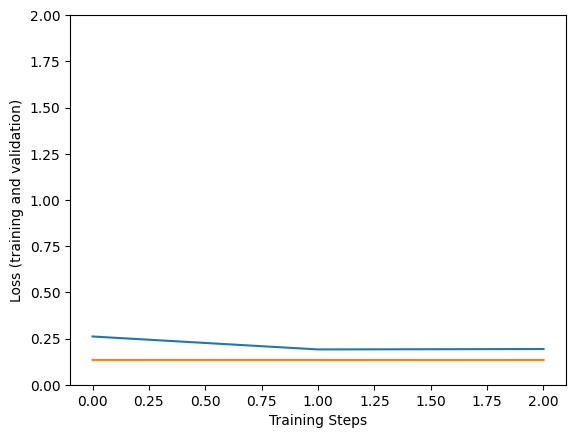

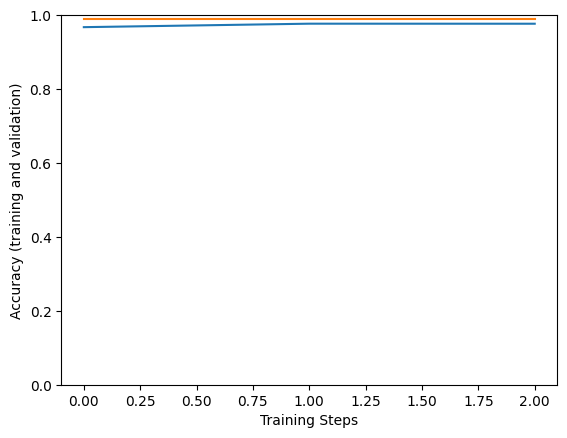

In [14]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [15]:
if not os.path.exists('/content/drive/MyDrive/ImgSim/'):
    os.mkdir('/content/drive/MyDrive/ImgSim/')

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save('/content/drive/MyDrive/ImgSim/bit_feature_extractor', save_format='tf')

saved_model_path = '/content/drive/MyDrive/ImgSim/bit_model'
tf.saved_model.save(model, saved_model_path)

Image Vectorization

In [16]:
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [17]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [18]:
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model('/content/drive/MyDrive/ImgSim/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1"
  module = hub.load(module_handle)

In [19]:
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [20]:
for filename in tqdm(img_paths[:5000]):
    img = load_img(str(filename))
    features = module(img)
    feature_set = np.squeeze(features)
    outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
    out_path_file = os.path.join(imgvec_path, outfile_name)
    np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [09:22<00:00,  8.88it/s]


Testing using a sample

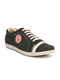

In [21]:
test_img = '/content/Fashion_data/categories/Footwear/14492.jpg'
dispImage(test_img)

In [22]:
styles = pd.read_csv('/content/styles.csv', on_bad_lines='skip')
styles['id'] = styles['id'].astype('str')
root_path = '/content/drive/MyDrive/ImgSim/'
styles.to_csv(root_path+'/styles.csv', index=False)

In [23]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [24]:
# Defining data structures as empty dict
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configuring annoy parameters
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Reads all file names which stores feature vectors
allfiles = glob.glob('/content/img_vectors/*.npz')

t = AnnoyIndex(dims, metric='angular')

In [25]:
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass
  t.add_item(findex, file_vector)

5000it [00:23, 215.06it/s]


In [26]:
t.build(trees)
t.save('t.ann')

True

In [27]:
file_path = '/content/drive/MyDrive/ImgSim/'

In [28]:
t.save(file_path+'indexer.ann')
pickle.dump(file_index_to_file_name, open(file_path+"file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(file_path+"file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(file_path+"file_index_to_product_id.p", "wb"))

Local Testing

We will randomly select an image and then find the top-K most visually similar images within our dataset.

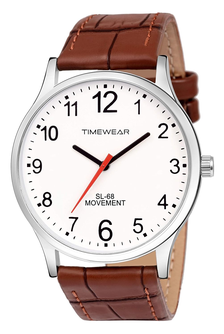

In [44]:
img_addr = 'https://images-na.ssl-images-amazon.com/images/I/81%2Bd6eSA0eL._UL1500_.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth, hsize), Image.Resampling.LANCZOS)
img

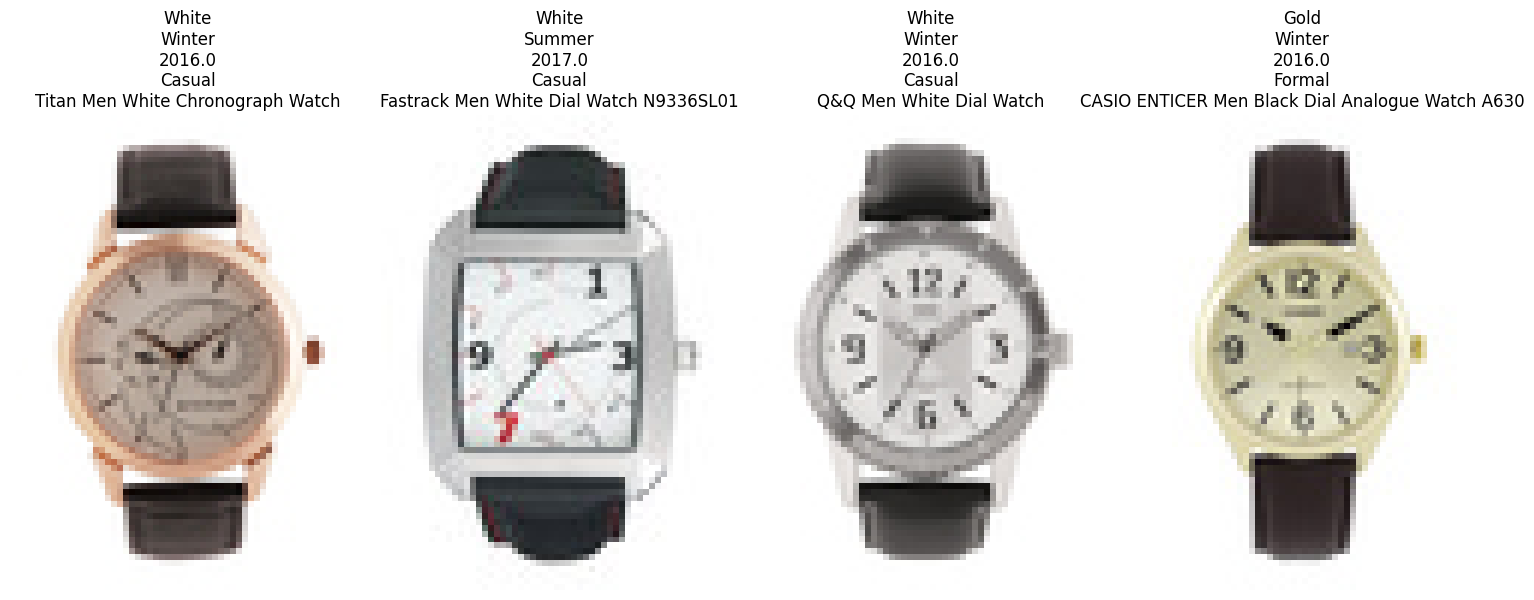

In [45]:
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(15, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()

Example with another products

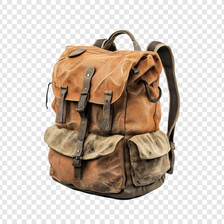

In [46]:
img_addr = 'https://img.freepik.com/free-psd/worn-brown-leather-backpack-canvas-pockets-travel-bag-vintage-style-adventure-gear-outdoor-equipment-hiking-rucksack-distressed-look-stylish-accessory_632498-29679.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth, hsize), Image.Resampling.LANCZOS)
img

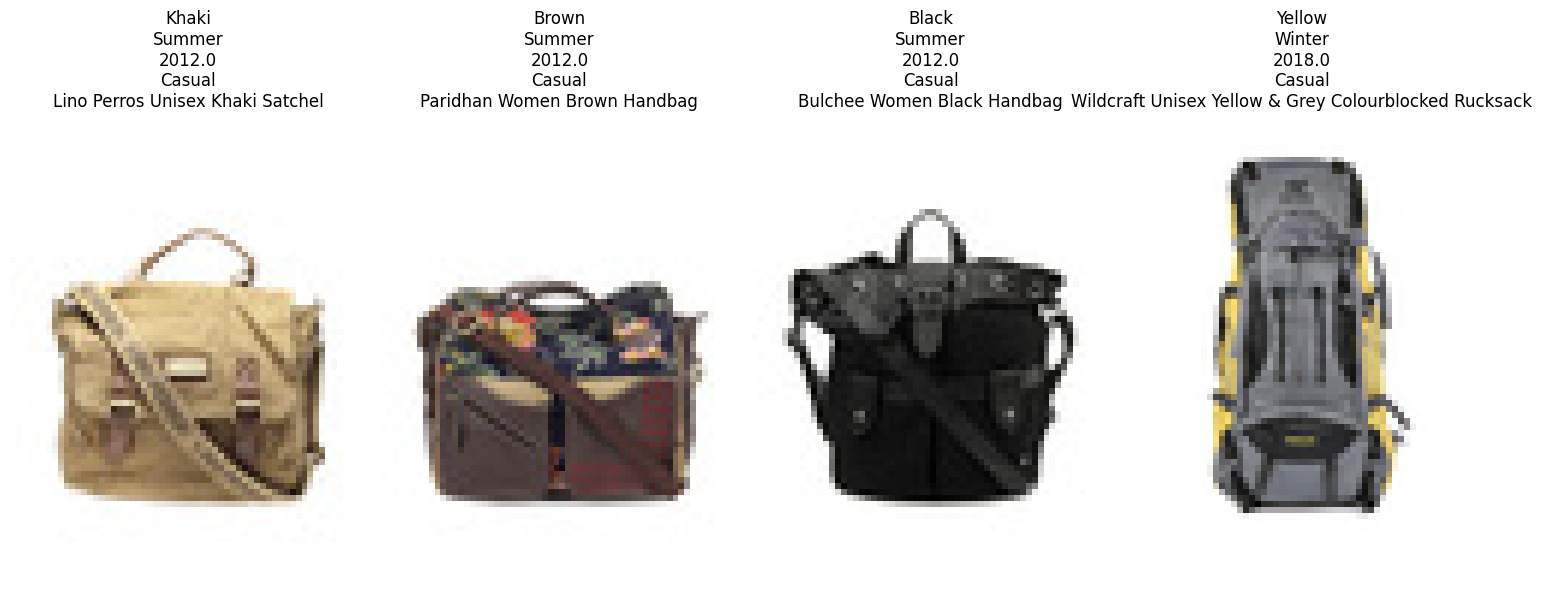

In [47]:
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(15, 10))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()

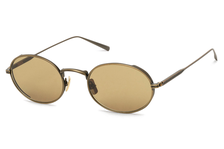

In [48]:
img_addr = 'https://www.specscollective.com/cdn/shop/files/jpg-antique-angle-sunglsses-tejesta.jpg'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth, hsize), Image.Resampling.LANCZOS)
img

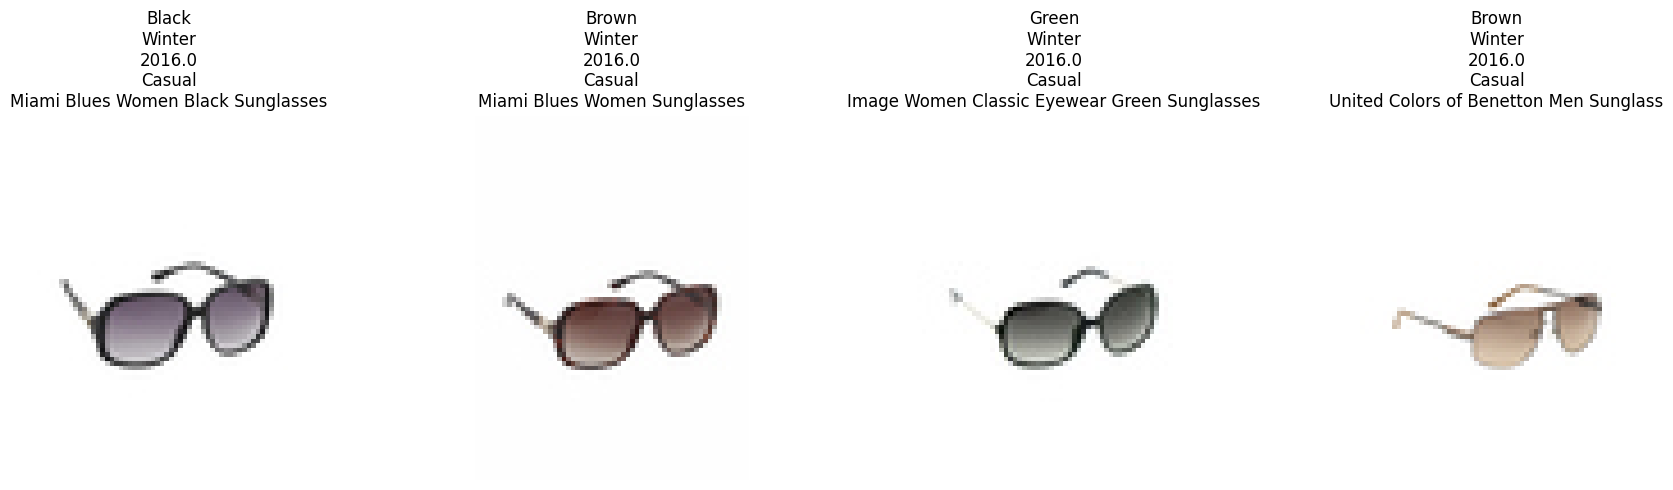

In [52]:
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = t.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(18, 5))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()